# MDC_52P88_EP 2025 --- RNA subproject

## 1. Load data

In [1]:
import os
import glob
from IPython.core.display import HTML

We get to load the data given by the directory 'MDC_52P88_EP-benchmark' in the following structure structure:

In [2]:
benchmark_data = {
    "k7": {
        "S_box": [
            ["ACGU...", "AC-U...", "AGGU..."],  # Instance 1 (Alignment)
            ["CCGA...", "CC-A...", "CCGG..."],  # Instance 2
            # ... up to 5 instances
        ],
        "tRNA": [
            ["GCAG...", "GCGG...", "UGGA..."],  # Instance 1
            # ...
        ]
    },
    "k10": {
        # ... similar structure for 10-way alignments
    }
}

In [3]:
def parse_fasta_alignment(file_path):
    """Lit un fichier FASTA d'alignement (gère le multi-ligne)."""
    alignments = []
    current_seq = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            if line.startswith(">"):
                if current_seq:
                    alignments.append("".join(current_seq))
                    current_seq = []
            else:
                current_seq.append(line)
        if current_seq:
            alignments.append("".join(current_seq))
    return alignments

def load_limited_benchmark(root_path, limit=5):
    """
    Charge au maximum 'limit' fichiers par famille d'ARN.
    Structure : data[k_val][family] = [liste d'alignements]
    """
    data = {}
    
    # On parcourt les dossiers k (ex: k5, k7, k10)
    for k_dir in os.listdir(root_path):
        k_path = os.path.join(root_path, k_dir)
        if not os.path.isdir(k_path): continue
        
        data[k_dir] = {}
        
        # On parcourt les familles (ex: S_box, tRNA)
        for family in os.listdir(k_path):
            family_path = os.path.join(k_path, family)
            if not os.path.isdir(family_path): continue
            
            data[k_dir][family] = []
            
            # On récupère tous les fichiers .fa dans la famille
            files = glob.glob(os.path.join(family_path, "*.fa"))
            
            # On ne prend que les 'limit' premiers fichiers
            for i in range(min(len(files), limit)):
                sequences = parse_fasta_alignment(files[i])
                data[k_dir][family].append(sequences)
                
            print(f"Charged {len(data[k_dir][family])} instances for {k_dir}/{family}")
            
    return data

# --- Utilisation ---
path = "MDC_52P88_EP-benchmark"
benchmark_data = load_limited_benchmark(path, limit=5)

Charged 5 instances for k5/5S_rRNA
Charged 5 instances for k5/Intron_gpII
Charged 5 instances for k5/U1
Charged 5 instances for k5/Hammerhead_1
Charged 5 instances for k5/SRP_bact
Charged 5 instances for k5/S_box
Charged 5 instances for k5/yybP-ykoY
Charged 5 instances for k5/gcvT
Charged 5 instances for k5/SECIS
Charged 1 instances for k5/IRES_HCV
Charged 5 instances for k5/5_8S_rRNA
Charged 5 instances for k5/tRNA
Charged 1 instances for k5/K_chan_RES
Charged 5 instances for k5/Histone3
Charged 3 instances for k5/Entero_CRE
Charged 5 instances for k5/Hammerhead_3
Charged 3 instances for k5/HCV_SLVII
Charged 5 instances for k5/U2
Charged 5 instances for k5/UnaL2
Charged 5 instances for k5/SRP_euk_arch
Charged 5 instances for k5/Cobalamin
Charged 5 instances for k5/Lysine
Charged 1 instances for k5/HIV_GSL3
Charged 5 instances for k5/THI
Charged 5 instances for k10/5S_rRNA
Charged 5 instances for k10/Intron_gpII
Charged 5 instances for k10/U1
Charged 5 instances for k10/SRP_bact
Charge

### 1.1 Building subset of each families

## 2. Alignment and folding algorithms

In [4]:
import RNA
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns

import tempfile
from IPython.display import SVG

### 2.1 Helper functions

#### 2.1.A Pairs to bracket

In [5]:
def pairs_to_dot_bracket(n, base_pairs):
    structure = ["."] * n

    for i, j in base_pairs:
        structure[i-1] = "("
        structure[j-1] = ")"
        
    return "".join(structure)

In [6]:
n = 13
pairs = [(2,8), (3,7), (9,13)]
print(pairs_to_dot_bracket(n, pairs))

.((...))(...)


#### 2.1.B Bracket to pair

In [7]:
def parse_RNA_structure(dbstring):
    base_pairs = []
    stack = []
    
    for index, char in enumerate(dbstring):
        position = index + 1  
        
        if char == '(':
            stack.append(position)
        elif char == ')':
            if not stack:
                raise ValueError(f"Erreur à la position {position} : parenthèse fermante sans correspondante.")
            opening_pos = stack.pop()
            base_pairs.append((opening_pos, position))
        elif char == '.':
            continue
        else:
            raise ValueError(f"Caractère invalide '{char}' détecté à la position {position}.")
            
    if stack:
        raise ValueError(f"Erreur : {len(stack)} parenthèse(s) ouvrante(s) non fermée(s) (positions : {stack}).")
        
    return sorted(base_pairs)

In [8]:
try:
    print(parse_RNA_structure(".((...))(...).")) # Succès
    # print(parse_RNA_structure("((.)) )"))      # Erreur : Trop de fermantes
    # print(parse_RNA_structure("((.(..))"))      # Erreur : Trop d'ouvrantes
except ValueError as e:
    print(f"Erreur de parsing : {e}")

[(2, 8), (3, 7), (9, 13)]


#### 2.1.C is_canonical(sequence, dbstring)

In [9]:
def is_canonical_basepair(x, y):
    """Vérifie si deux bases x et y forment une paire autorisée."""
    pair = {x, y} 

    if pair == {'A', 'U'} or pair == {'C', 'G'}:
        return True

    if pair == {'G', 'U'}:
        return True
        
    return False

def is_canonical(sequence, dbstring):
    """
    Vérifie si la structure (dbstring) est canonique pour la séquence donnée.
    """
    try:
        base_pairs = parse_RNA_structure(dbstring)
    except ValueError as e:
        print(f"Structure invalide : {e}")
        return False

    for i, j in base_pairs:
        # Rappel : les indices de parse_RNA_structure commencent à 1
        base_i = sequence[i-1]
        base_j = sequence[j-1]
        
        if not is_canonical_basepair(base_i, base_j):
            return False 
            
    return True

In [10]:
# --- Example ---
seq = "CGCUUAGCGAAUC"
struct = ".((...))(...)"

if is_canonical(seq, struct):
    print("La structure est canonique !")
else:
    print("La structure contient des paires interdites.")

La structure est canonique !


#### 2.1.D RNA Class projection

In [11]:
class RnaMolecule:
    def __init__(self, sequence, structure=None):
        self.sequence = sequence.upper()
        if structure is None:
            self.structure = "." * len(sequence)
        else:
            if len(sequence) != len(structure):
                raise ValueError("La séquence et la structure doivent avoir la même longueur.")
            self.structure = structure

    def __str__(self):
        return f"Sequence:  {self.sequence}\nStructure: {self.structure}"

def project_structure(alignment_seq, consensus_db):
    gap_indices = {i + 1 for i, char in enumerate(alignment_seq) if char == '-'}
    all_pairs = parse_RNA_structure(consensus_db)

    projected_pairs = []
    for i, j in all_pairs:
        if i not in gap_indices and j not in gap_indices:
            projected_pairs.append((i, j))

    # 4. Create the new sequence without gaps
    new_sequence = alignment_seq.replace('-', '')
    
    # 5. Create a new structure (y); we create a mapping : index_dans_alignement -> index_dans_new_seq
    mapping = {}
    current_new_idx = 1
    for i, char in enumerate(alignment_seq):
        if char != '-':
            mapping[i + 1] = current_new_idx
            current_new_idx += 1
            
    # We adjust with the new indices
    final_pairs = [(mapping[i], mapping[j]) for i, j in projected_pairs]
    final_db = pairs_to_dot_bracket(len(new_sequence), final_pairs)
    
    return new_sequence, final_db

In [12]:
class RnaMolecule:

    @classmethod
    def from_alignment(cls, alignment_seq, consensus_db):
        """
        Create a RnaMolecule instance by projecting a consensus structure onto an alignment sequence.
        """
        seq, db = project_structure(alignment_seq, consensus_db)
        return cls(seq, db)

In [13]:
def expand_structure_to_alignment(alignment_seq, single_db):
    """
    Insert gaps into the single sequence structure to match the alignment sequence.
    """
    expanded_structure = []
    current_idx = 0
    
    for char in alignment_seq:
        if char == '-':
            # Si c'est un gap dans l'alignement, on met un point dans la structure
            expanded_structure.append('.')
        else:
            # Sinon, on prend le caractère correspondant dans la structure prédite
            expanded_structure.append(single_db[current_idx])
            current_idx += 1
            
    return "".join(expanded_structure)

#### 2.1.E Plot a structure with RNAplot

In [14]:
def plot_rna_structure(sequence, structure):
    """Plot with RNA library"""
    # On crée un objet RNA fold pour calculer la structure
    fp = tempfile.NamedTemporaryFile(suffix="svg")
    RNA.svg_rna_plot(sequence, structure, fp.name)
    return SVG(fp.name)

In [15]:
def plot_two_structures_side_by_side(seq, struct1, label1, struct2, label2):
    """Génère et affiche deux structures ARN côte à côte."""
    
    def get_svg_content(s, st):
        with tempfile.NamedTemporaryFile(suffix=".svg", delete=False) as fp:
            RNA.svg_rna_plot(s, st, fp.name)
            with open(fp.name, 'r') as f:
                content = f.read()
        os.unlink(fp.name) # Nettoyage
        return content

    svg1 = get_svg_content(seq, struct1)
    svg2 = get_svg_content(seq, struct2)

    # Création d'un container HTML pour l'affichage côte à côte
    html_content = f"""
    <div style="display: flex; justify-content: space-around; text-align: center;">
        <div style="flex: 1;">
            <h3>{label1}</h3>
            {svg1}
        </div>
        <div style="flex: 1;">
            <h3>{label2}</h3>
            {svg2}
        </div>
    </div>
    """
    display(HTML(html_content))

#### 2.1.F get_structure_energy

In [16]:
def get_structure_energy(sequence, structure):
    """Calcule l'énergie libre d'une structure donnée pour une séquence."""
    fc = RNA.fold_compound(sequence)
    return fc.eval_structure(structure)

### 2.2 Nussinov algorithm

In [17]:
def nussinov_algorithm_matrix(seq,m):
    """Copmpute max number of base pairs in seq[0..n-1] using Nussinov algorithm"""
    # Initialisation
    n = len(seq)
    dp = np.zeros((n, n), dtype=int)

    traceback = np.zeros((n, n), dtype=object)

    for i in range(n-1, -1, -1):
        for j in range(i+1, n):
            if j - i <= m:
                continue

            best = 0
            # appariement i-j
            if is_canonical_basepair(seq[i], seq[j]):
                val = dp[i+1][j-1] + 1
                if val > best:
                    best = val
                    traceback[i][j] = 'PAIR'

            # split
            for k in range(i+1, j):
                val = dp[i][k] + dp[k+1][j]
                if val > best:
                    best = val
                    traceback[i][j] = ('SPLIT',k)

            dp[i][j] = best
    
    return dp, traceback

def get_pairs(traceback, i, j):
    if i >= j:
        return []
    
    decision = traceback[i][j]
    
    if decision == 'PAIR':
        # if we get a pair, evoluate inside
        return [(i+1, j+1)] + get_pairs(traceback, i + 1, j - 1)
    
    elif isinstance(decision, tuple) and decision[0] == 'SPLIT':
        # divise the problem at the indice k
        k = decision[1]
        return get_pairs(traceback, i, k) + get_pairs(traceback, k + 1, j)
    
    else:
        return []


The following function allows to run the Nussinow algorithm on a single sequence to predict its strucuture.

In [18]:
def compute_nussinov_structure(seq, m):
    """Compute the RNA structure in dot-bracket notation using Nussinov algorithm with a minimum loop length m."""
    dp, traceback = nussinov_algorithm_matrix(seq, m)
    pairs = get_pairs(traceback, 0, len(seq) - 1)
    return pairs_to_dot_bracket(len(seq), pairs)

Sequence: GCACGACG
Structure (m=3): ...(...)


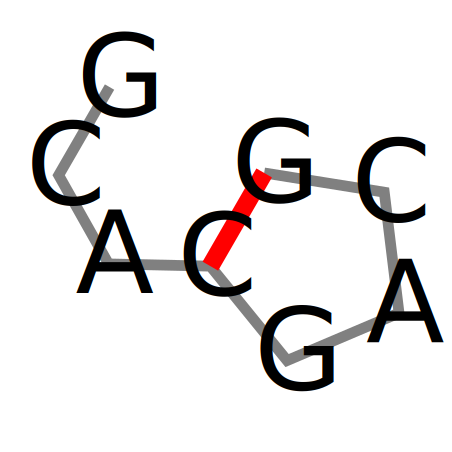

In [19]:
# --- Example ---
seq = "GCACGACG"
m = 3
structure = compute_nussinov_structure(seq, m)
print(f"Sequence: {seq}")
print(f"Structure (m={m}): {structure}")

plot_rna_structure(seq, structure)

### 2.3 MTA

#### 2.3.A Self coded MTA

In [20]:
# Accuracy evaluation
def calculate_unpaired_acc(predicted_pairs, index):
    """Renvoie l'accuracy à partir des séquences dot-bracket à l'indice i"""
    n = len(predicted_pairs)
    acc = 0
    for i in range(n):
        if predicted_pairs[i][index] == '.':
            acc += 1
    return acc

def calculate_paired_acc(predicted_pairs, l, index_i, index_j):
    """Renvoie l'accuracy à partir des séquences dot-bracket à l'indice i pour les paired bases"""
    n = len(predicted_pairs)
    acc = 0
    for i in range(n):
        if predicted_pairs[i][index_i] == '(' and predicted_pairs[i][index_j] == ')':
            compteur = 0

            for inside_i in range(index_i+1, index_j):
                if predicted_pairs[i][inside_i] == '(':
                    compteur += 1
                if predicted_pairs[i][inside_i] == ')':
                    compteur -= 1
            
            if compteur == 0:
                acc += 1
    return 2*l*acc

In [21]:
# MTA
def mta_structure(alignments, l, m):
    """Renvoie la mta structure"""
    n = len(alignments)
    n_largeur = len(alignments[0])
    structures = []

    
    for seq in alignments:
        #Vienna
        #sequence = seq.replace('-', '')
        md = RNA.md()
        fc = RNA.fold_compound(seq, md)
        (ss, mfe) = fc.mfe()
        #nussinov_matrix, traceback = nussinov_algorithm_matrix(seq, m)
        #base_pairs = get_pairs(traceback, 0, len(seq)-1)
        #dot_brackets = pairs_to_dot_bracket(len(seq), sorted(base_pairs))
        structures.append(ss)

    F = np.zeros((n_largeur,n_largeur))

    #Initialisation
    for i in range(n_largeur):
        for j in range(m+i):
            if j >= n_largeur:
                break
            s = 0
            for k in range(i,j+1):
                s += calculate_unpaired_acc(structures,k)
            F[i,j] = s
    
    # Recurse
    for i in range(n_largeur-1, -1, -1):
        for j in range(i+1,n_largeur):
            mx = 0
            for k in range(i+1, j+1):
                if j >= n_largeur or i >= n_largeur:
                    break
                if F[i,k-1] + F[k,j] > mx:
                    mx = F[i,k-1] + F[k,j]
            
            F[i,j] = max(mx, F[i+1,j-1] + calculate_paired_acc(structures, l, i, j))


    # Traceback
    # start traceback at F(1,n)
    consensus = ['.'] * n_largeur

    def tb_rec(i, j):
        if i > j:
            return
        
        elif i == j : 
            consensus[i] = "."
            return 

        elif (F[i][j] == F[i+1][j-1] + calculate_paired_acc(structures, l, i, j)) :
            consensus[i] = "("
            consensus[j] = ")"
            tb_rec(i+1, j-1)
            return 
        
        for k in range(i+1, j+1):
            if F[i][j] == F[i][k-1] + F[k][j]:
                tb_rec(i, k-1)
                tb_rec(k, j)
                return 

    tb_rec(0, n_largeur-1)

    return "".join(consensus), F, structures

In [22]:
def compute_self_coded_mta(alignments, l, m):
    """
    Compute the MTA structure for the given alignments.
    Returns the consensus structure, the F matrix, and the individual structures for each sequence in the alignment.
    """
    consensus, F, structures = mta_structure(alignments, l, m)
    return consensus, F, structures

In [23]:
def test_mta_structure(alignment_test, l, m):
    # Vérif rapide : toutes même longueur
    L = len(alignment_test[0])
    assert all(len(s) == L for s in alignment_test), "the sequences in the alignment must all have the same length"


    # --- Appel et affichage ---
    consensus, F, structures = compute_self_coded_mta(alignment_test, l, m)

    print("=== Alignements (entrée) ===")
    for s in alignment_test:
        print(s)

    print("\n=== Structures prédites ===")
    if structures is not None:
        for db in structures:
            print(db)
    else:
        print("(non retournées par mta_structure)")

    print("\n=== Consensus (sortie) ===")
    print(consensus)

In [24]:
def consensus_sequence(alignments):
    """Donne une séquence la plus probable"""
    n = len(alignments[0])
    consensus_seq = []
    
    for i in range(n):
        counts = {"A": 0, "C": 0, "G": 0, "U": 0, "-": 0}

        for seq in alignments:
            counts[seq[i]] += 1

        # lettre la plus fréquente à la position i
        consensus_base = max(counts, key=counts.get)
        consensus_seq.append(consensus_base)

    return "".join(consensus_seq)    

=== Alignements (entrée) ===
CGCAAA-GCG
CGGAAAACCG

=== Structures prédites ===
(((....)))
(((....)))

=== Consensus (sortie) ===
(((....)))


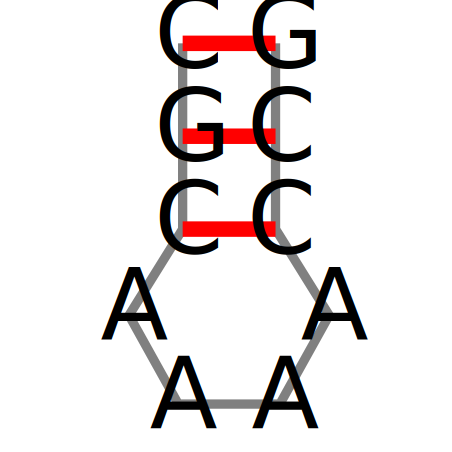

In [25]:
# --- Example ---
alignment_test = [ "CGCAAA-GCG", "CGGAAAACCG"]
# l : calculate_paired_acc (2*l*acc)
l = 1
m = 3

test_mta_structure(alignment_test, l, m)

predicted_consensus = "(((....)))"
consensus_seq = consensus_sequence(alignment_test)
plot_rna_structure(consensus_seq, predicted_consensus)

#### 2.3.B Vienna RNA package

In [26]:
def mfe_structure(sequence):
    md = RNA.md()
    fc = RNA.fold_compound(sequence, md)
    (ss, mfe) = fc.mfe()
    return ss, mfe

def get_all_individual_mfes(alignment):
    individual_results = []
    for seq_ali in alignment:
        seq_pure = seq_ali.replace('-', '')
        ss, mfe = mfe_structure(seq_pure)
        individual_results.append((seq_pure, ss, mfe))
    return individual_results

def compare_structures(alignment):
    # 1. Calcul Alifold
    fc_ali = RNA.fold_compound(alignment)
    ali_ss, ali_mfe = fc_ali.alifold()
    
    for i, seq_ali in enumerate(alignment):
        # MFE de la séquence seule
        seq_pure, ss_single, _ = get_all_individual_mfes(alignment)[i]
        # Projection du consensus
        _, ss_proj = project_structure(seq_ali, ali_ss)
        
        print(f"Séquence {i}:")
        print(f"  MFE Single: {ss_single}")
        print(f"  Alifold Pr: {ss_proj}")
        
        # Plot (ViennaRNA génère des fichiers .ps)
        RNA.export_structure_plot(seq_pure, ss_single, f"single_{i}.ps")
        RNA.export_structure_plot(seq_pure, ss_proj, f"alifold_proj_{i}.ps")

def get_unpaired_probs_from_fc(fc, length):
    """Calcule le profil unpaired à partir d'un fold_compound."""
    fc.pf() # Obligatoire pour les probabilités
    bpp = fc.bpp() # Matrice de probabilité de paires
    
    unpaired_probs = np.ones(length)
    for i in range(1, length + 1):
        sum_p = 0
        for j in range(1, length + 1):
            if i != j:
                sum_p += bpp[i][j] if i < j else bpp[j][i]
        unpaired_probs[i-1] -= sum_p
    return unpaired_probs

def get_avg_unpaired_probs_single(alignment):
    """Calcule la moyenne des probabilités unpaired des séquences seules."""
    n_cols = len(alignment[0])
    all_profiles = []

    for seq_ali in alignment:
        seq_pure = seq_ali.replace('-', '')
        n_pure = len(seq_pure) # Correction : on utilise la longueur réelle de la séquence
        
        if n_pure == 0: continue
            
        # 2. Repliement individuel
        fc = RNA.fold_compound(seq_pure)
        p_unpaired = get_unpaired_probs_from_fc(fc, n_pure)

        # 3. Remappage vers les colonnes de l'alignement
        # On replace les probabilités aux positions où il n'y a pas de gaps
        col_profile = np.zeros(n_cols)
        cursor = 0
        for col, char in enumerate(seq_ali):
            if char != '-':
                col_profile[col] = p_unpaired[cursor]
                cursor += 1
            else:
                # Optionnel : On peut mettre 1.0 pour les gaps (toujours non-appariés)
                # ou 0.0 selon la convention de ton benchmark.
                col_profile[col] = 1.0 
                
        all_profiles.append(col_profile)
    return np.mean(all_profiles, axis=0)

def plot_profiles(alignment):
    """Génère le graphique de comparaison (Point D)."""
    # 1. Profil Single moyen
    avg_single = get_avg_unpaired_probs_single(alignment)
    
    # 2. Profil Alifold
    fc_ali = RNA.fold_compound(alignment)
    ali_unpaired = get_unpaired_probs_from_fc(fc_ali, len(alignment[0]))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(avg_single, label="Moyenne des séquences seules (Single)", color='blue', lw=1.5)
    plt.plot(ali_unpaired, label="Alifold (Consensus)", color='red', linestyle='--', alpha=0.8)
    
    plt.fill_between(range(len(avg_single)), avg_single, color='blue', alpha=0.1)
    plt.xlabel("Colonnes de l'alignement")
    plt.ylabel("Probabilité d'être non-apparié")
    plt.title("Comparaison des profils d'accessibilité (Unpaired Probabilities)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Quantification (Point E)
    eps = 1e-6
    diff = np.sum(np.abs(np.log((avg_single + eps) / (ali_unpaired + eps))))
    print(f"Différence totale (Log-Ratio) : {diff:.4f}")

Structure Alifold:
(((((((..((((........))))((((((.......))))))...............(((((.......))))))))))))



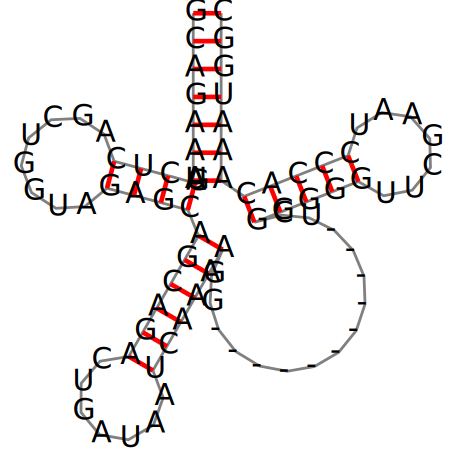

In [27]:
# --- Example ---
alignment = ["GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC",
"GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC",
"GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC",
"GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC",
"GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC"
]

md = RNA.md()
fc = RNA.fold_compound(alignment, md)
(ali_ss, mfe) = fc.mfe()
print(f"Structure Alifold:\n{ali_ss}\n")
plot_rna_structure(consensus_sequence(alignment), ali_ss)

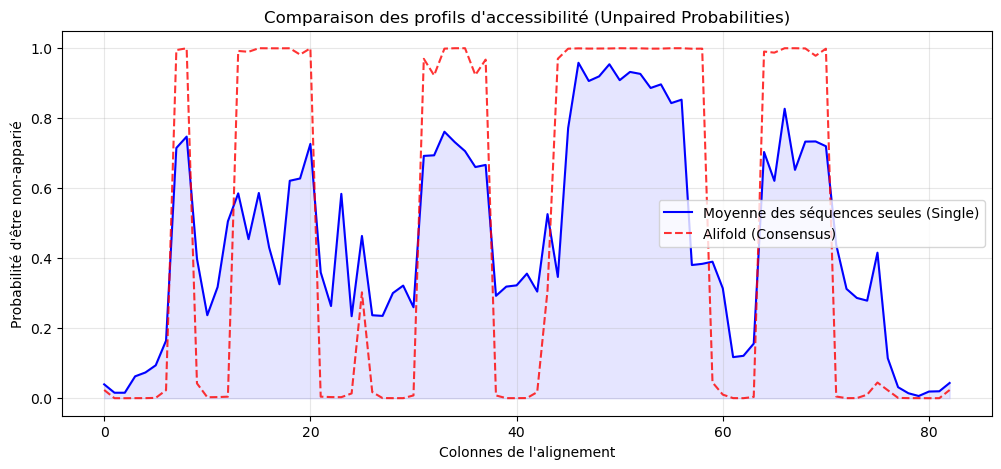

Différence totale (Log-Ratio) : 203.1790


In [28]:
# --- Test du Point D/E (Profils) ---
plot_profiles(alignment)

### 2.4 MEA

In the context of RNA structure prediction using the Maximum Expected Accuracy (MEA) framework, these two parameters act as the "dials" you turn to balance physical thermodynamics with evolutionary history.

1. The λ (l_factor) controls the trade-off between base pairs and unpaired bases in your predicted structure.

- It defines how much "credit" the algorithm gets for forming a pair versus leaving a base single-stranded.

- High λ: Heavily favors forming base pairs. This leads to a more "crowded" structure with many stems, which can increase Sensitivity (finding all possible pairs) but might decrease Specificity (adding false positives).

- Low λ: Prefers unpaired bases, resulting in a "leaner" structure with fewer, but more certain, pairs.


2. The α (alpha) parameter represents the weight assigned to the Conservation Score (the evolutionary signal).

- α=0 (Classic MEA): Your algorithm ignores the alignment's history. It relies purely on the physical probabilities (thermodynamics) calculated for each sequence individually.

- High α: The algorithm prioritizes pairs that are "biologically coherent" across the entire alignment. It seeks out compensatory mutations (e.g., a G-C pair in one sequence and an A-U pair in another at the same position).

- The Trade-off: With a high α, the algorithm might choose a pair that looks "physically weak" (low probability in a single sequence) if that pair is perfectly conserved across all other sequences in the alignment. 

We will these parameters wisely in the part `3.5 Choice of parameters`.

In [29]:
def seq_without_gap(alignment_seq):
    """
    Extract the sequence without gaps and create a mapping from the pure sequence indices to the alignment indices.
    Returns:
    - seq_pure: the string without '-' characters
    - mapping: a dictionary { pure_index (1-based) : alignment_index (0-based) }
    """
    seq_pure = ""
    mapping = {}
    current_pure_idx = 1
    
    for i, char in enumerate(alignment_seq):
        if char != '-':
            seq_pure += char
            mapping[current_pure_idx] = i
            current_pure_idx += 1
            
    return seq_pure, mapping

In [ ]:
def get_mea_probabilities_with_mapping(alignments, l_factor):
    """
    Get the MEA probabilities for unpaired and paired bases with mapping from pure sequence to alignment columns.
    """
    n_cols = len(alignments[0])
    unpaired_acc = np.zeros(n_cols)
    paired_acc = np.zeros((n_cols, n_cols))
    
    for seq in alignments:
        # APPEL DE TA NOUVELLE FONCTION
        seq_pure, mapping = seq_without_gap(seq)
        n = len(seq_pure)
        
        # Calcul ViennaRNA sur la séquence réelle
        fc = RNA.fold_compound(seq_pure)
        fc.pf()
        
        # Initialisation locale pour cette séquence
        current_seq_paired = np.zeros((n_cols, n_cols))
        
        # Re-mapping des probabilités de paires
        bpp = fc.bpp()

        for i_pure in range(1, n + 1):
            for j_pure in range(i_pure + 1, n + 1):
                prob = bpp[i_pure][j_pure]
                if prob > 0:
                    col_i = mapping[i_pure]
                    col_j = mapping[j_pure]
                    current_seq_paired[col_i, col_j] = prob
        
        # Calcul des probabilités Unpaired (p_u)
        current_seq_unpaired = np.ones(n_cols)
        for i in range(n_cols):
            # Somme des probas où i est impliqué (en tant que premier ou deuxième membre)
            sum_p_ij = np.sum(current_seq_paired[i, :]) + np.sum(current_seq_paired[:, i])
            
            # Si c'est un gap, sum_p_ij sera 0, donc p_u reste 1.0 (Logique !)
            current_seq_unpaired[i] = max(0, 1.0 - sum_p_ij)

        # Accumulation pour l'alignement
        unpaired_acc += current_seq_unpaired
        paired_acc += (2 * l_factor * current_seq_paired)
        
    return unpaired_acc, paired_acc

def compute_conservation_score(alignments):
    n_cols = len(alignments[0])
    n_seqs = len(alignments)
    cons_matrix = np.zeros((n_cols, n_cols))
    
    valid_pairs = {'AU', 'UA', 'GC', 'CG', 'GU', 'UG'}
    
    for i in range(n_cols):
        for j in range(i + 4, n_cols):
            bonus = 0
            penalty = 0
            for seq in alignments:
                b1, b2 = seq[i].upper(), seq[j].upper()
                if b1 == '-' or b2 == '-': # Gap pénalisé
                    penalty += 1
                elif (b1 + b2) in valid_pairs:
                    bonus += 1
                else: # Paire impossible (ex: A-G) pénalisée
                    penalty += 1
            
            # On combine bonus et pénalité (on peut ajuster le poids de la pénalité)
            cons_matrix[i, j] = (bonus - penalty) / n_seqs
            
    return cons_matrix

def get_mea_probabilities_with_conservation_score(alignments, l_factor, alpha):
    """
    Combine les probabilités MEA avec le score de conservation.
    alpha : poids accordé au signal évolutif (conservation).
    """
    # 1. Calcul des probabilités de base (ton code précédent)
    unpaired_acc, paired_acc = get_mea_probabilities_with_mapping(alignments, l_factor)
    
    # 2. Calcul du score de conservation
    cons_score = compute_conservation_score(alignments)
    
    # 3. Fusion : PAIR(i,j) = Probabilités + (alpha * Conservation) 
    # On ajoute le signal de conservation à la matrice des paires
    paired_acc_final = paired_acc + (alpha * cons_score)
    
    return unpaired_acc, paired_acc_final

def mea_structure(alignments, unpaired_probs, paired_probs, min_dist):
    """ Calcule la structure MEA à partir des alignements en utilisant les probabilités de paires et non-paires avec mapping. """
    n_cols = len(alignments[0])
    
    # Matrice F pour la DP
    F = np.zeros((n_cols, n_cols))
    
    for k in range(1, n_cols):
        for i in range(n_cols - k):
            j = i + k
            
            # Options : unpaired i, unpaired j, paired (i,j), or bifurcation
            opts = [
                unpaired_probs[i] + F[i+1, j],
                unpaired_probs[j] + F[i, j-1]
            ]
            
            if k > min_dist:
                opts.append(paired_probs[i, j] + F[i+1, j-1])
            
            # Bifurcation
            for m in range(i, j):
                opts.append(F[i, m] + F[m+1, j])
                
            F[i, j] = max(opts)

    # Traceback
    consensus_structure = ["."] * n_cols

    def tb(i, j):
        if i >= j: return
        if F[i, j] == unpaired_probs[i] + F[i+1, j]:
            tb(i+1, j)
        elif F[i, j] == unpaired_probs[j] + F[i, j-1]:
            tb(i, j-1)
        elif i + min_dist < j and F[i, j] == paired_probs[i, j] + F[i+1, j-1]:
            consensus_structure[i], consensus_structure[j] = "(", ")"
            tb(i+1, j-1)
        else:
            for m in range(i, j):
                if F[i, j] == F[i, m] + F[m+1, j]:
                    tb(i, m)
                    tb(m+1, j)
                    break

    tb(0, n_cols - 1)
    return "".join(consensus_structure)

### 2.5 MEA Sparsified

In [31]:
def mea_structure_sparsified(unpaired_probs, paired_probs, m):
    n = len(unpaired_probs)
    F = np.zeros(n + 1) # On peut optimiser en 1D ou 2D selon la variante
    # Ici, implémentation inspirée du document source page 16
    F = np.zeros((n, n))
    
    for i in range(n):
        F[i, i] = unpaired_probs[i] # Init [cite: 188, 193]

    for j in range(n):
        candidates = [] # Liste des i qui font une bonne paire avec j [cite: 243]
        for i in reversed(range(j)):
            # Cas 1 : j est non apparié [cite: 246]
            f_score = F[i, j-1] + unpaired_probs[j]
            
            # Cas 2 : j est apparié avec un k précédent (Sparsification) [cite: 250]
            for k, c_score_kj in candidates:
                if i < k:
                    f_score = max(f_score, F[i, k-1] + c_score_kj)
            
            # Cas 3 : On teste si (i, j) lui-même est un bon candidat [cite: 252]
            if j - i > m:
                # Score de la paire (i, j) + structure interne
                c_ij = paired_probs[i, j] + F[i+1, j-1]
                if c_ij > f_score:
                    f_score = c_ij
                    candidates.append((i, c_ij)) # Ajout aux candidats [cite: 255]
            
            F[i, j] = f_score
    
    # Traceback
    consensus_structure = ["."] * n

    def tb(i, j):
        if i >= j: return
        if F[i, j] == unpaired_probs[i] + F[i+1, j]:
            tb(i+1, j)
        elif F[i, j] == unpaired_probs[j] + F[i, j-1]:
            tb(i, j-1)
        elif i + m < j and F[i, j] == paired_probs[i, j] + F[i+1, j-1]:
            consensus_structure[i], consensus_structure[j] = "(", ")"
            tb(i+1, j-1)
        else:
            for k in range(i, j):
                if F[i, j] == F[i, k] + F[k+1, j]:
                    tb(i, k)
                    tb(k+1, j)
                    break

    tb(0, n - 1)
    return "".join(consensus_structure)

In [32]:
alignment_test = ["CGCAAA-GCG", "CGGAAAACCG"]

print("--- Verification of the Mapping ---")
for i, s in enumerate(alignment_test):
    pure, mapping = seq_without_gap(s)
    print(f"Original Sequence {i}   : {s}")
    print(f"Pure Sequence     {i}   : {pure}")
    print(f"Mapping (Pure -> Aln) : {mapping}\n")

print("--- MEA ---")
start = time.time()
unpairedprobs, paired_probs = get_mea_probabilities_with_conservation_score(alignment_test, l_factor=1.0, alpha=0.5)
struct_mea = mea_structure(alignment_test,unpairedprobs, paired_probs, min_dist=2)
end = time.time()
print(f"Process time of MEA : {end - start:.4f} secondes")
print(f"Final MEA Structure : {struct_mea}")


start = time.time()
struct_mea_sparsified = mea_structure_sparsified(*get_mea_probabilities_with_conservation_score(alignment_test, l_factor=1.0, alpha = 0.5), m=2)
end = time.time()
print(f"Process time of Sparsified MEA : {end - start:.4f} secondes")
print(f"Final Sparsified MEA Structure : {struct_mea_sparsified}")


--- Verification of the Mapping ---
Original Sequence 0   : CGCAAA-GCG
Pure Sequence     0   : CGCAAAGCG
Mapping (Pure -> Aln) : {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 7, 8: 8, 9: 9}

Original Sequence 1   : CGGAAAACCG
Pure Sequence     1   : CGGAAAACCG
Mapping (Pure -> Aln) : {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}

--- MEA ---
Process time of MEA : 0.0086 secondes
Final MEA Structure : (((....)))
Process time of Sparsified MEA : 0.0150 secondes
Final Sparsified MEA Structure : (((....)))


### 2.6 MEA Boltzmann Sampling

In [33]:
def calculate_partition_function(unpaired_probs, paired_probs, beta, m=3):
    """
    Computes the partition function Z[i,j] for an RNA alignment.
    Based on the recursion: Z[i,j] = Z[i,j-1]*exp(beta*UNP(j)) + sum(...) [cite: 292-295]
    """
    n = len(unpaired_probs)
    # Z matrix including an extra index for Z[i, i-1] = 1.0 cases
    Z = np.zeros((n + 1, n + 1), dtype=np.float64)
    
    # Initialization [cite: 293]
    for i in range(n):
        Z[i, i] = np.exp(beta * unpaired_probs[i])
        Z[i, i-1] = 1.0
    if n > 0: Z[n, n-1] = 1.0

    # DP Recursion [cite: 292]
    for length in range(1, n):
        for i in range(n - length):
            j = i + length
            
            # Case 1: j is unpaired
            # Z[i, j] = Z[i, j-1] * exp(beta * UNP(j))
            z_val = Z[i, j-1] * np.exp(beta * unpaired_probs[j])
            
            # Case 2: j is paired with some k [cite: 295]
            # sum over k: Z[i, k-1] * exp(beta * PAIR(k,j)) * Z[k+1, j-1]
            for k in range(i, j - m):
                # Handle the k=i case where Z[i, k-1] is Z[i, i-1] = 1.0
                term_left = Z[i, k-1] if k > i else 1.0
                z_val += term_left * np.exp(beta * paired_probs[k, j]) * Z[k+1, j-1]
                
            Z[i, j] = z_val
            
    return Z

def stochastic_traceback(i, j, Z, unpaired_probs, paired_probs, beta, structure, m=3):
    """
    Produces a random substructure for indices i..j based on partition function Z [cite: 300-301].
    """
    if j < i:
        return

    # Select a random float for selecting the case [cite: 304]
    x = np.random.uniform(0, Z[i, j])
    
    # Check Case: j is unpaired [cite: 306]
    z_unpaired = (Z[i, j-1] if j > i else 1.0) * np.exp(beta * unpaired_probs[j])
    
    if x < z_unpaired:
        stochastic_traceback(i, j-1, Z, unpaired_probs, paired_probs, beta, structure, m)
        return

    # Check Case: j is paired with k [cite: 309]
    cumulative_z = z_unpaired
    for k in range(i, j - m):
        term_left = Z[i, k-1] if k > i else 1.0
        z_paired = term_left * np.exp(beta * paired_probs[k, j]) * Z[k+1, j-1]
        cumulative_z += z_paired
        
        if x < cumulative_z:
            structure[k] = "("
            structure[j] = ")"
            # Recursively sample the two independent sub-problems [cite: 314]
            stochastic_traceback(i, k-1, Z, unpaired_probs, paired_probs, beta, structure, m)
            stochastic_traceback(k+1, j-1, Z, unpaired_probs, paired_probs, beta, structure, m)
            return

def sample_structures(unpaired_probs, paired_probs, beta, num_samples=1000, m=3):
    """Generates a list of sampled RnaMolecule structures."""
    n = len(unpaired_probs)
    Z = calculate_partition_function(unpaired_probs, paired_probs, beta, m)
    
    samples = []
    for _ in range(num_samples):
        struct_list = ["."] * n
        stochastic_traceback(0, n - 1, Z, unpaired_probs, paired_probs, beta, struct_list, m)
        samples.append("".join(struct_list))
    return samples

High beta low temp: best sol
decrease of beta : should be convergence

In [34]:
def plot_probability_heatmap(samples):
    """Estimates and visualizes base pair probabilities from samples."""
    n = len(samples[0])
    prob_matrix = np.zeros((n, n))
    
    for s in samples:
        pairs = parse_RNA_structure(s) # Using your existing parse/pair function
        for i, j in pairs:
            # Note: handle 1-based vs 0-based indexing carefully
            prob_matrix[i-1, j-1] += 1
            
    prob_matrix /= len(samples)
    
    plt.imshow(prob_matrix, cmap='hot_r')
    plt.title(f"Estimated Base Pair Probabilities ({len(samples)} samples)")
    plt.colorbar(label="Probability")
    plt.show()

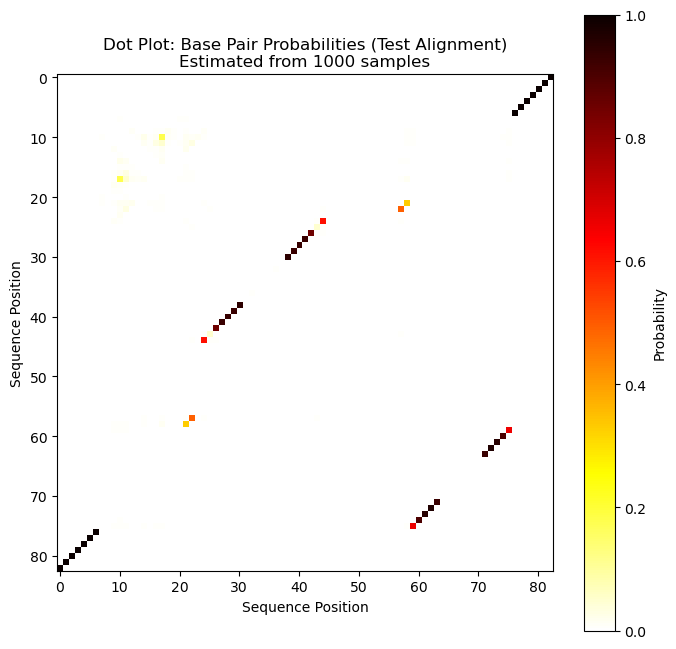

In [35]:
def plot_dot_plot(samples, sequence_name="RNA Sequence"):
    """
    Visualizes base pair probabilities using imshow to create a Dot Plot.
    
    Args:
        samples (list): List of dot-bracket strings from stochastic sampling.
        sequence_name (str): Name of the sequence for the plot title.
    """
    n = len(samples[0])
    # Initialize a matrix to store pair frequencies
    prob_matrix = np.zeros((n, n))
    
    # 1. Count base pair occurrences in samples
    for structure in samples:
        # Use your existing parse function to get pairs
        pairs = parse_RNA_structure(structure)
        for i, j in pairs:
            # Convert 1-based indexing from parse_RNA_structure to 0-based for numpy
            prob_matrix[i-1, j-1] += 1
            # Dot plots are often symmetric
            prob_matrix[j-1, i-1] += 1
            
    # 2. Normalize to get probabilities (0.0 to 1.0)
    prob_matrix /= len(samples)
    
    # 3. Create the plot using imshow
    plt.figure(figsize=(8, 8))
    # 'hot_r' (reversed hot) shows high probability as dark/red and low as white
    plt.imshow(prob_matrix, cmap='hot_r', interpolation='nearest')
    
    plt.title(f"Dot Plot: Base Pair Probabilities ({sequence_name})\nEstimated from {len(samples)} samples")
    plt.xlabel("Sequence Position")
    plt.ylabel("Sequence Position")
    plt.colorbar(label="Probability")

# --- Exemple d'utilisation ---
alignment_test = ["GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC",
"GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC",
"GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC",
"GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC",
"GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC"
]
unpaired_probs, paired_probs = get_mea_probabilities_with_conservation_score(alignment_test, l_factor=1.0, alpha=0.5)
beta = 1.0
samples = sample_structures(unpaired_probs, paired_probs, beta, num_samples=1000, m=2)
plot_dot_plot(samples, sequence_name="Test Alignment")

#### Boltzman with exponential rescaling

In [36]:
def calculate_partition_function_stable(unpaired_probs, paired_probs, beta, m=3):
    """Computes the partition function with a scaling factor to prevent overflow."""
    n = len(unpaired_probs)
    Z = np.zeros((n + 1, n + 1), dtype=np.float64)
    
    avg_score = (np.mean(unpaired_probs) + np.mean(paired_probs)) 
    scale = np.exp(beta * avg_score * 1.1)

    # Initialization
    for i in range(n):
        Z[i, i] = np.exp(beta * unpaired_probs[i]) / scale
        Z[i, i-1] = 1.0
    if n > 0: Z[n, n-1] = 1.0

    # DP Recursion with scaling
    for length in range(1, n):
        for i in range(n - length):
            j = i + length
            # Scale unpaired case
            z_val = (Z[i, j-1] * np.exp(beta * unpaired_probs[j])) / scale
            
            # Scale paired cases
            for k in range(i, j - m):
                term_left = Z[i, k-1] if k > i else 1.0
                # Double-scaling factor for the two joined sub-problems
                z_val += (term_left * np.exp(beta * paired_probs[k, j]) * Z[k+1, j-1]) / (scale**2)
                
            Z[i, j] = z_val
            
    return Z, scale

def stochastic_traceback_stable(i, j, Z, unpaired_probs, paired_probs, beta, scale, structure, m=3):
    """Produces a random substructure using the scaled partition function."""
    if j < i:
        return
    
    x = np.random.uniform(0, Z[i, j])

    z_unpaired = (Z[i, j-1] if j > i else 1.0) * np.exp(beta * unpaired_probs[j]) / scale
    
    if x < z_unpaired:
        stochastic_traceback_stable(i, j-1, Z, unpaired_probs, paired_probs, beta, scale, structure, m)
        return

    cumulative_z = z_unpaired
    for k in range(i, j - m):
        term_left = Z[i, k-1] if k > i else 1.0
        z_paired = (term_left * np.exp(beta * paired_probs[k, j]) * Z[k+1, j-1]) / (scale**2)
        cumulative_z += z_paired
        
        if x < cumulative_z:
            structure[k], structure[j] = "(", ")"
            stochastic_traceback_stable(i, k-1, Z, unpaired_probs, paired_probs, beta, scale, structure, m)
            stochastic_traceback_stable(k+1, j-1, Z, unpaired_probs, paired_probs, beta, scale, structure, m)
            return

def sample_structures_stable(unpaired_probs, paired_probs, beta, num_samples=1000, m=3):
    """Generates samples using the stable partition function."""
    n = len(unpaired_probs)
    # Calculate Z and the scale factor used
    Z, scale = calculate_partition_function_stable(unpaired_probs, paired_probs, beta, m)
    
    samples = []
    for _ in range(num_samples):
        struct_list = ["."] * n
        stochastic_traceback_stable(0, n - 1, Z, unpaired_probs, paired_probs, beta, scale, struct_list, m)
        samples.append("".join(struct_list))
    return samples

## 3. Evaluation

### 3.1 Benchmark

#### Precision, Recall, F-measure

In [37]:
def benchmark_counts(reference, prediction):
    """
    Runs a benchmark comparing the reference and predicted RNA structures.
    Returns the counts of True Positives (TP), False Positives (FP), and False Negatives (FN).
    """
    ref_pairs = set(parse_RNA_structure(reference))
    pred_pairs = set(parse_RNA_structure(prediction))

    TP = len(ref_pairs & pred_pairs)
    FP = len(pred_pairs - ref_pairs)
    FN = len(ref_pairs - pred_pairs)

    return TP, FP, FN

def benchmark_metrics(reference, prediction):
    """
    Calculates precision, recall, and F-measure based on the benchmark counts.
    """
    TP, FP, FN = benchmark_counts(reference, prediction)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f_measure = TP / (TP + 0.5 * (FP + FN)) if (TP + FP + FN) > 0 else 0.0

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": precision,
        "Recall": recall,
        "F-measure": f_measure
    }

Ensemble diversity
Local position entropy
Local reliability measure

In [38]:
reference = ".((.((....)))).(((....))..)"
prediction = "(((.((...).))).(((....))))"

metrics = benchmark_metrics(reference, prediction)
for k, v in metrics.items():
    print(f"{k}: {v}")

TP: 5
FP: 3
FN: 2
Precision: 0.625
Recall: 0.7142857142857143
F-measure: 0.6666666666666666


#### Ensemble Diversity

In [39]:
def base_pair_distance(struct1, struct2):
    """Calculates the distance between two structures based on their base pairs."""
    pairs1 = set(parse_RNA_structure(struct1))
    pairs2 = set(parse_RNA_structure(struct2))
    # Symmetric difference: pairs in 1 or 2 but not both
    return len(pairs1.symmetric_difference(pairs2))

def calculate_ensemble_diversity(samples):
    """Calculates the average pairwise distance within the ensemble."""
    n = len(samples)
    if n < 2: return 0
    
    distances = []
    # We sample a subset of pairs if the ensemble is large (e.g., 1000) to save time
    num_comparisons = min(500, n * (n - 1) // 2)
    for _ in range(num_comparisons):
        s1, s2 = np.random.choice(samples, 2, replace=False)
        distances.append(base_pair_distance(s1, s2))
        
    return np.mean(distances)

#### Local Reliability

1. Reliability is directly derived from the probabilities of the predicted MEA structure.
2. Entropy is calculated using the formula: H = -sum(p_i * log2(p_i)) where p_i are the probabilities of the base being in each possible state (paired with j or unpaired).
    - For paired states, we consider the probabilities from the prob_matrix; for the unpaired state, we consider the probability from unpaired_probs.
    - The resulting entropy gives us a measure of how uncertain the structural prediction is for each base, with higher values indicating more uncertainty.
    - The reliability score indicates how confident we are in the predicted state of each base, with higher values indicating more confidence.

In [40]:
def get_mea_reliability(mea_structure, prob_matrix, unpaired_probs):
    """
    Get the reliability of each base in the MEA structure based on the probabilities of pairs and unpaired states.
    Returns an array of reliability scores for each position in the MEA structure.
    """
    n = len(mea_structure)
    reliability = np.zeros(n)
    mea_pairs = parse_RNA_structure(mea_structure)

    pair_map = {}
    for i, j in mea_pairs:
        pair_map[i-1] = j-1
        pair_map[j-1] = i-1
        
    for i in range(n):
        if i in pair_map:
            # Pairs
            j = pair_map[i]
            reliability[i] = prob_matrix[i, j]
        else:
            # Unpaired
            reliability[i] = unpaired_probs[i]
            
    return reliability

def get_probabilities_from_samples(samples):
    """
    Get the matrix of base pair probabilities and the vector of unpaired probabilities from a list of sampled structures.
    """
    n = len(samples[0])
    num_samples = len(samples)
    
    # Initialisation
    prob_matrix = np.zeros((n, n))
    unpaired_counts = np.zeros(n)
    
    for s in samples:
        pairs = parse_RNA_structure(s)
        for i, j in pairs:
            prob_matrix[i-1, j-1] += 1
            prob_matrix[j-1, i-1] += 1
            
        for i, char in enumerate(s):
            if char == '.':
                unpaired_counts[i] += 1
                
    prob_matrix /= num_samples
    unpaired_probs = unpaired_counts / num_samples
    
    return prob_matrix, unpaired_probs

def calculate_local_measures(samples, prob_matrix, unpaired_probs):
    """
    Calculates local measures of structural reliability (based on probabilities) and uncertainty (Shannon entropy) for each base in the sequence.
    Returns two arrays: reliability and entropy, each of length equal to the sequence length.
    """
    n = len(unpaired_probs)
    entropy = np.zeros(n)
    
    # 1. Calcul de l'Entropie Locale
    # Pour chaque base i, on regarde ses probas d'appariement avec tout j + proba unpaired
    for i in range(n):
        # On récupère toutes les probas impliquant i
        p_row = prob_matrix[i, :]
        p_unp = unpaired_probs[i]
        
        # On ne garde que les probas significatives pour éviter log(0)
        probs = np.concatenate(([p_unp], p_row[p_row > 1e-6]))
        entropy[i] = -np.sum(probs * np.log2(probs))
        
    return entropy

### 3.2 Comparison for single sequence folding algorithms: Nussinov and Vienna RNAalifold

In [41]:
alignment = ["GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC",
"GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC",
"GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC",
"GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC",
"GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC"
]

# Comparison for a single sequence (ex: the first one) between Nussinow and ViennaRNA
seq = alignment[0].replace('-', '')

nussinov_structure = compute_nussinov_structure(seq, m=3)
vienna_structure, vienna_mfe = mfe_structure(seq)
nussinov_energy = get_structure_energy(seq, nussinov_structure)

print(f"Comparison for sequence: {seq}")
print(f"Nussinov : {nussinov_energy:.2f} kcal/mol")
print(f"ViennaMFE: {vienna_mfe:.2f} kcal/mol")

plot_two_structures_side_by_side(
    seq, 
    nussinov_structure, f"Nussinov ({nussinov_energy:.2f} kcal/mol)",
    vienna_structure, f"ViennaRNA MFE ({vienna_mfe:.2f} kcal/mol)"
)

Comparison for sequence: GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGGUCGGCGGUUCGAGCCCGUCAUCCUCC
Nussinov : -2.90 kcal/mol
ViennaMFE: -29.60 kcal/mol


### 3.3 Comparison between single sequence folding and alignment folding

In [42]:
alignment_test = ["GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC",
"GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC",
"GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC",
"GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC",
"GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC"
]

alignment_seq = alignment_test[0] 
seq_pure = alignment_seq.replace('-', '')
vienna_structure_pure, vienna_mfe = mfe_structure(seq_pure)
vienna_structure_aligned = expand_structure_to_alignment(alignment_seq, vienna_structure_pure)


consensus_seq = consensus_sequence(alignment_test)
alifold_structure, alifold_mfe = mfe_structure(consensus_seq)

plot_two_structures_side_by_side(
    alignment_seq, 
    alifold_structure, f"Alifold MFE ({alifold_mfe:.2f})",
    vienna_structure_aligned, f"ViennaRNA MFE ({vienna_mfe:.2f})"
)

### 3.4 Comparison for MEA (Maximum Expected Accuracy)

#### 3.4.A Standard MEA vs RNAalifold (MFE)

In [43]:
# Comparison of MEA with Alifold
alignment = ["GGAGGAUUAGCUCAGCUGGGAGAGCAUCUGCCUUACAAGCAGAGGG-----------UCGGCGGUUCGAGCCCGUCAUCCUCC",
"GCCUUCCUAGCUCAG-UGGUAGAGCGCACGGCUUUUAACCGUGUGG-----------UCGUGGGUUCGAUCCCCACGGAAGGC",
"GCCUUUAUAGCUUAG-UGGUAAAGCGAUAAACUGAAGAUUUAUUUA-----------CAUGUAGUUCGAUUCUCAUUAAGGGC",
"GCGGAUAUAACUUAGGGGUUAAAGUUGCAGAUUGUGGCUCUGAAAA------------CACGGGUUCGAAUCCCGUUAUUCGC",
"GGAAAAUU-GAUCAUCGGCAAGAUAAGUUAUUUACUAAAUAAUAGGAUUUAAUAACCUGGUGAGUUCGAAUCUCACAUUUUCC"
]

l_factor = 1.0
alpha = 10
unpaired_probs, paired_probs = get_mea_probabilities_with_conservation_score(alignment, l_factor, alpha)
mea_struct = mea_structure(alignment_test, unpaired_probs, paired_probs, m)
mfe_mea = get_structure_energy(consensus_seq, mea_struct)

# ViennaRNA for alignment consensus
consensus_seq = consensus_sequence(alignment)
alifold_structure, alifold_mfe = mfe_structure(consensus_seq)

plot_two_structures_side_by_side(
    consensus_seq,
    alifold_structure, f"Alifold MFE ({alifold_mfe:.2f})",
    mea_struct, f"MEA Structure (alpha={alpha}), Energy: {mfe_mea:.2f}"
)   

#### 3.4.B Standard MEA vs MEA with conservation score

In [44]:
def compare_conservation_impact(alignment, m, l_factor, alpha):
    """
    Compare the influence of the conservation score on the MEA structure 
    by evaluating the covariance score of the predicted structures with and without conservation.
    Returns the MEA structures for both cases.
    """
    # 1. Préparation du Fold Compound pour l'alignement
    fc = RNA.fold_compound(alignment)
    
    # 2. Prédiction MEA Standard (sans conservation -> alpha = 0)
    # On récupère les probas avec alpha=0
    unp_std, pair_std = get_mea_probabilities_with_conservation_score(alignment, l_factor, alpha=0)
    struct_std = mea_structure(alignment, unp_std, pair_std, m)
    
    # 3. Prédiction MEA Bis (avec conservation -> alpha choisi)
    unp_bis, pair_bis = get_mea_probabilities_with_conservation_score(alignment, l_factor, alpha)
    struct_bis = mea_structure(alignment, unp_bis, pair_bis, m)
    
    # 4. Évaluation des scores de covariance via ViennaRNA
    score_std = fc.eval_covar_structure(struct_std)
    score_bis = fc.eval_covar_structure(struct_bis)
    
    # 5. Affichage des résultats
    print("--- Analysis of the impact of the conservation ---")
    print(f"{'Method':<20} | {'Covariance Score':<20}")
    print("-" * 45)
    print(f"{'MEA Standard':<20} | {score_std:<20.2f}")
    print(f"{'MEA Conservation':<20} | {score_bis:<20.2f}")
    
    improvement = ((score_bis - score_std) / abs(score_std)) * 100 if score_std != 0 else 0
    print(f"\n Improvement of the evolution signal : {improvement:.2f}%")
    
    return struct_std, struct_bis

compare_conservation_impact(alignment, m = 3, l_factor=1.0, alpha=10)

--- Analysis of the impact of the conservation ---
Method               | Covariance Score    
---------------------------------------------
MEA Standard         | 6.56                
MEA Conservation     | 8.56                

 Improvement of the evolution signal : 30.49%


('(((((((...............(.(.(((((.......))))).)............).((((.........)))))))))))',
 '((((((((.((((.(....).)))).(((((.(...).)))))..).............((((((...)..))))))))))))')

### 3.5 Choice of parameters

#### 3.5.A Sensitivity Dial `l_factor`

In [45]:
def grid_search_lambda(benchmark_data, families, best_alpha, k_val='k7', lambda_list=[0.5, 1.0, 1.5, 2.0, 3.0]):
    """
    Performs a Grid Search for the best l_factor (lambda) while keeping alpha fixed.
    Uses the sparsified MEA for faster benchmarking.
    """
    results_by_lambda = {l: [] for l in lambda_list}
    
    for family in families:
        if family not in benchmark_data[k_val]: continue
        
        print(f"Benchmarking Family: {family}...")
        alignments = benchmark_data[k_val][family]
        
        for l_val in lambda_list:
            f_scores = []
            for alignment in alignments:
                # 1. Reference: RNAalifold
                fc_ali = RNA.fold_compound(alignment)
                (ref_ss, _) = fc_ali.mfe()
                
                # 2. Get probabilities with current lambda and fixed alpha
                # Note: l_factor scales the physical paired probabilities
                unp, pair = get_mea_probabilities_with_conservation_score(
                    alignment, l_factor=l_val, alpha=best_alpha
                )
                
                # 3. Prediction using the Sparsified MEA
                pred_ss = mea_structure_sparsified(unp, pair, m=3)
                
                # 4. Calculate F-measure using your custom metrics
                metrics = benchmark_metrics(ref_ss, pred_ss)
                f_scores.append(metrics["F-measure"])
            
            avg_f = np.mean(f_scores)
            results_by_lambda[l_val].append(avg_f)
            print(f"  l_factor {l_val:.2f} -> Avg F-measure: {avg_f:.4f}")
            
    return results_by_lambda

In [46]:
def plot_lambda_grid_search(results_by_lambda):
    """Plots the F-measure results across the lambda range."""
    lambdas = sorted(list(results_by_lambda.keys()))
    # Global mean across all 5 families
    mean_scores = [np.mean(results_by_lambda[l]) for l in lambdas]

    plt.figure(figsize=(10, 6))
    plt.plot(lambdas, mean_scores, marker='s', linestyle='--', color='darkorange', lw=2)
    
    best_l = lambdas[np.argmax(mean_scores)]
    plt.axvline(x=best_l, color='red', linestyle=':', label=f'Best l_factor: {best_l}')

    plt.title("Optimization of l_factor (Base Pair Weighting)")
    plt.xlabel("l_factor (λ)")
    plt.ylabel("Mean F-measure")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Benchmarking Family: 5S_rRNA...
  l_factor 0.50 -> Avg F-measure: 0.9450
  l_factor 1.00 -> Avg F-measure: 0.9437
  l_factor 1.50 -> Avg F-measure: 0.9338
  l_factor 2.00 -> Avg F-measure: 0.9241
  l_factor 2.50 -> Avg F-measure: 0.9026
  l_factor 3.00 -> Avg F-measure: 0.9002
  l_factor 3.50 -> Avg F-measure: 0.8979
  l_factor 4.00 -> Avg F-measure: 0.8933
  l_factor 4.50 -> Avg F-measure: 0.8832
  l_factor 5.00 -> Avg F-measure: 0.8832
Benchmarking Family: Intron_gpII...
  l_factor 0.50 -> Avg F-measure: 0.9747
  l_factor 1.00 -> Avg F-measure: 0.9648
  l_factor 1.50 -> Avg F-measure: 0.9565
  l_factor 2.00 -> Avg F-measure: 0.9397
  l_factor 2.50 -> Avg F-measure: 0.9272
  l_factor 3.00 -> Avg F-measure: 0.9227
  l_factor 3.50 -> Avg F-measure: 0.9143
  l_factor 4.00 -> Avg F-measure: 0.9063
  l_factor 4.50 -> Avg F-measure: 0.9063
  l_factor 5.00 -> Avg F-measure: 0.8899
Benchmarking Family: U1...
  l_factor 0.50 -> Avg F-measure: 0.8839
  l_factor 1.00 -> Avg F-measure: 0.8789
  l

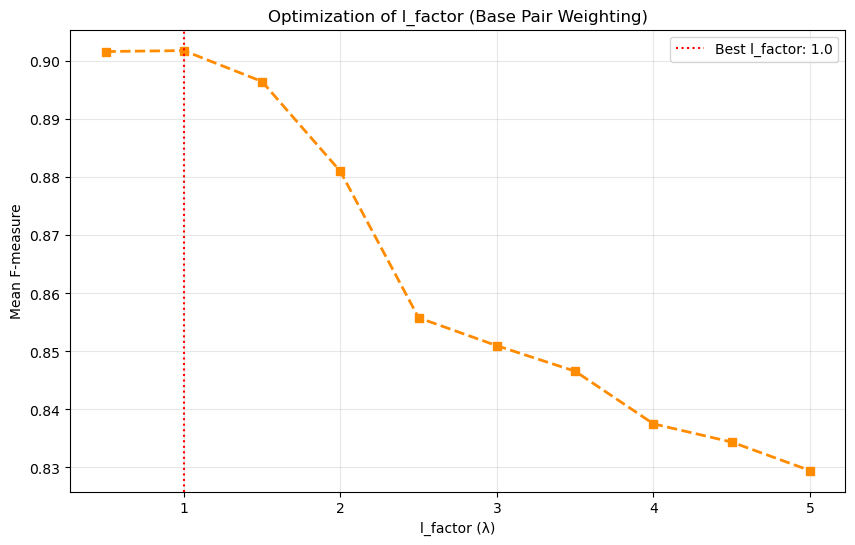

In [47]:
# --- Execution for 5 Families ---
# Assuming you found 10.0 to be a good alpha from your previous test
best_alpha_found = 10.0 
families_to_test = list(benchmark_data['k7'].keys())[:5]
lambda_range = np.linspace(0.5, 5.0, 10)

results_lambda = grid_search_lambda(benchmark_data, families_to_test, best_alpha_found, lambda_list=lambda_range)
plot_lambda_grid_search(results_lambda)

#### 3.5.B Conservation score influence `alpha`

In [48]:
def grid_search_alpha(benchmark_data, families, k_val, alpha_list):
    """
    Test differents values of alpha on the benchmark and collect F-measures for each family and alpha.
    """
    results_by_alpha = {alpha: [] for alpha in alpha_list}
    
    for family in families:
        if family not in benchmark_data[k_val]: continue
        
        print(f"Family : {family}")
        alignments = benchmark_data[k_val][family]
        
        for alpha in alpha_list:
            f_scores = []
            for alignment in alignments:
                # 1. On génère la structure de référence (via RNAalifold pour le test) [cite: 109]
                fc_ali = RNA.fold_compound(alignment)
                (ref_ss, _) = fc_ali.mfe()
                
                # 2. Prédiction avec ton MEA Bis
                unp, pair = get_mea_probabilities_with_conservation_score(alignment, l_factor=1.0, alpha=alpha)
                res_mea = mea_structure_sparsified(unp, pair, m=3) 
                
                # 3. Calcul de la F-measure avec TA fonction [cite: 139]
                metrics = benchmark_metrics(ref_ss, res_mea) # Note: res_mea est un RnaMolecule, utilise .structure
                f_scores.append(metrics["F-measure"])
            
            # Moyenne de la famille pour cet alpha
            avg_f = np.mean(f_scores)
            results_by_alpha[alpha].append(avg_f)
            #print(f"  Alpha {alpha:2} -> F-measure moyenne: {avg_f:.4f}")
            
    return results_by_alpha

In [49]:
def plot_grid_search(results_by_alpha):
    alphas = list(results_by_alpha.keys())
    # Moyenne globale sur toutes les familles testées
    mean_scores = [np.mean(results_by_alpha[a]) for a in alphas]

    plt.figure(figsize=(10, 6))
    plt.plot(alphas, mean_scores, marker='o', linestyle='-', color='teal', linewidth=2)
    
    # Mise en évidence du meilleur alpha
    best_idx = np.argmax(mean_scores)
    plt.annotate(f'Best Alpha: {alphas[best_idx]}', 
                 xy=(alphas[best_idx], mean_scores[best_idx]), 
                 xytext=(alphas[best_idx]+1, mean_scores[best_idx]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.title("Optimisation of Alpha (Conservation score)")
    plt.xlabel("Alpha")
    plt.ylabel("F-measure moyenne")
    plt.grid(True, alpha=0.3)
    plt.show()

Family : 5S_rRNA
Family : Intron_gpII
Family : U1
Family : Hammerhead_1
Family : SRP_bact


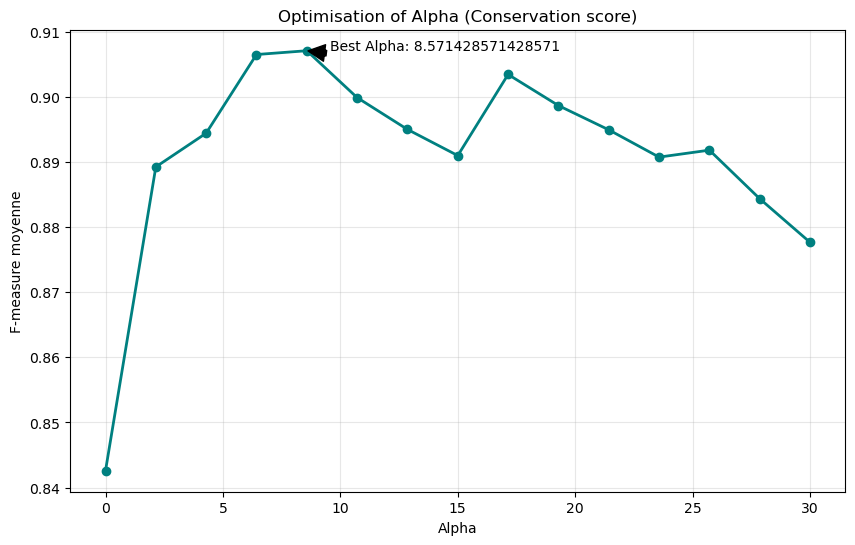

In [50]:
# --- Test ---
families_to_test = list(benchmark_data['k7'].keys())[:5] # Test sur 3 familles
alphas = np.linspace(0, 30, 15) 
results = grid_search_alpha(benchmark_data, families_to_test, k_val='k7', alpha_list=alphas)
plot_grid_search(results)

#### 3.5.C Sampling parameter: inverse of temperature `beta`

In [51]:
def optimize_beta(unpaired_probs, paired_probs, ref_structure, beta_range=np.linspace(0.1, 5.0, 10)):
    """
    Finds the beta that maximizes the average F-measure of the ensemble.
    """
    best_beta = 0
    max_avg_f = 0
    results = []

    for beta in beta_range:
        # Generate ensemble
        samples = sample_structures(unpaired_probs, paired_probs, beta, num_samples=100)
        
        # Calculate average performance of the ensemble
        f_scores = [benchmark_metrics(ref_structure, s)["F-measure"] for s in samples]
        avg_f = np.mean(f_scores)
        
        results.append((beta, avg_f))
        
        if avg_f > max_avg_f:
            max_avg_f = avg_f
            best_beta = beta
            
    return best_beta, results

In [52]:
def benchmark_beta_tradeoff(unpaired_probs, paired_probs, ref_struct, beta_range):
    accuracy_scores = []
    diversity_scores = []
    
    for beta in beta_range:
        # 1. Generate ensemble
        samples = sample_structures(unpaired_probs, paired_probs, beta, num_samples=200)
        
        # 2. Compute Accuracy (Mean F-measure)
        f_vals = [benchmark_metrics(ref_struct, s)["F-measure"] for s in samples]
        accuracy_scores.append(np.mean(f_vals))
        
        # 3. Compute Diversity
        div = calculate_ensemble_diversity(samples)
        diversity_scores.append(div)
        
        print(f"Beta: {beta:.2f} | Accuracy: {np.mean(f_vals):.4f} | Diversity: {div:.2f}")
        
    return accuracy_scores, diversity_scores

In [53]:
def plot_beta_optimization(beta_range, accuracy, diversity):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Accuracy on the left Y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Inverse Temperature (Beta)')
    ax1.set_ylabel('Mean Ensemble F-measure', color=color)
    ax1.plot(beta_range, accuracy, color=color, marker='o', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot Diversity on the right Y-axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Ensemble Diversity (BP Distance)', color=color)
    ax2.plot(beta_range, diversity, color=color, marker='s', linestyle='--', label='Diversity')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Beta Optimization: Finding the Biological Balance")
    fig.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

Beta: 0.01 | Accuracy: 0.0308 | Diversity: 37.38
Beta: 0.12 | Accuracy: 0.3354 | Diversity: 29.54
Beta: 0.23 | Accuracy: 0.6962 | Diversity: 17.91
Beta: 0.34 | Accuracy: 0.7954 | Diversity: 12.29
Beta: 0.45 | Accuracy: 0.8482 | Diversity: 8.80
Beta: 0.56 | Accuracy: 0.8707 | Diversity: 7.09
Beta: 0.67 | Accuracy: 0.8837 | Diversity: 5.82
Beta: 0.78 | Accuracy: 0.8854 | Diversity: 5.66
Beta: 0.89 | Accuracy: 0.8905 | Diversity: 4.73
Beta: 1.00 | Accuracy: 0.8885 | Diversity: 4.80


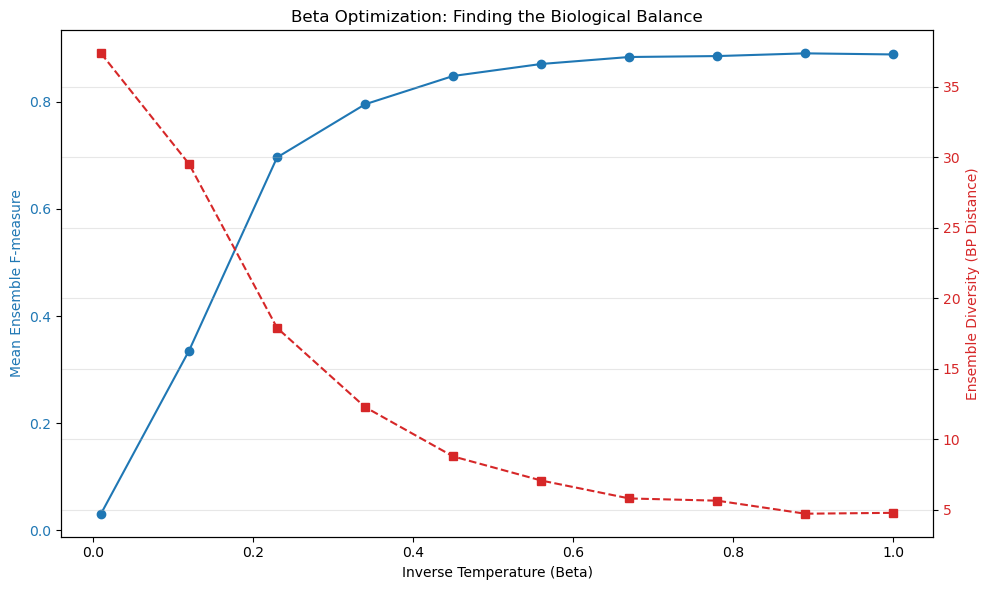

In [54]:
# --- Execution ---
beta_vals = np.linspace(0.01, 1.0, 10)
unp, pair = get_mea_probabilities_with_conservation_score(alignment, l_factor=1.0, alpha=8.5)
fc_ali = RNA.fold_compound(alignment)
ref = fc_ali.mfe()[0] # Structure de référence pour le benchmark
acc, div = benchmark_beta_tradeoff(unp, pair, ref, beta_vals)
plot_beta_optimization(beta_vals, acc, div)

We will choose `beta`= 0.2 to maximise the accuracy while preserving enough diversity, it allows also the exponential dependency to be limited.

## 4. Data analysis

### 4.1 Different RNA Family structural analysis

In [55]:
def run_family_benchmark(benchmark_data, k_target, alpha, l_factor=1.0):
    """
    Runs the benchmark for a specific k-way alignment set and alpha value.
    Correctly calculates probabilities for each instance to ensure valid F-measure.
    """
    all_results = []
    
    if k_target not in benchmark_data:
        print(f"Error: {k_target} not found in dataset.")
        return None

    for family, alignments in benchmark_data[k_target].items():
        print(f"Analyzing family: {family}...")
        
        for i, alignment in enumerate(alignments):
            # 1. Get the reference structure (e.g., using RNAalifold)
            fc_ali = RNA.fold_compound(alignment)
            ref_ss, _ = fc_ali.mfe() 
            
            # 2. CRITICAL FIX: Calculate probabilities for THIS specific alignment
            # This ensures the prediction matches the reference sequence length
            unp, pair = get_mea_probabilities_with_conservation_score(alignment, l_factor, alpha)
            
            # 3. Predict the structure using MEA Sparsified
            start = time.time()
            res_sparse_db = mea_structure_sparsified(unp, pair, m=3)
            t_sparse = time.time() - start
            
            # 4. Calculate metrics (Precision, Recall, F-measure)
            metrics_sparse = benchmark_metrics(ref_ss, res_sparse_db) 

            # 5. Store results
            res_entry = {
                "Family": family,
                "Instance": i,
                "Method": "MEA_Sparse",
                "Time": t_sparse,
                "k": k_target,
                **metrics_sparse # Includes F-measure, TP, FP, etc.
            }
            all_results.append(res_entry)
                
    return pd.DataFrame(all_results)

def plot_benchmark_results(df, k_val):
    """
    Visualizes the average F-measure per family and compares execution times.
    Sorts families by F-measure in descending order.
    """
    # Calculate the mean F-measure per family and method: group by Family and Method, then compute the mean
    summary = df.groupby(['Family', 'Method'])['F-measure'].mean().unstack()
    
    # Sort families by the overall average F-measure
    sorted_index = summary.mean(axis=1).sort_values(ascending=False).index
    summary = summary.reindex(sorted_index)
    

    ax = summary.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title(f"Average F-measure Comparison by RNA Family ({k_val}-way alignments)")
    plt.ylabel("F-measure Score")
    plt.xlabel("RNA Family (Sorted by performance)")
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    

    plt.tight_layout()
    plt.show()

Analyzing family: 5S_rRNA...
Analyzing family: Intron_gpII...
Analyzing family: U1...
Analyzing family: Hammerhead_1...
Analyzing family: SRP_bact...
Analyzing family: S_box...
Analyzing family: yybP-ykoY...
Analyzing family: gcvT...
Analyzing family: SECIS...
Analyzing family: 5_8S_rRNA...
Analyzing family: tRNA...
Analyzing family: Histone3...
Analyzing family: Entero_CRE...
Analyzing family: Hammerhead_3...
Analyzing family: U2...
Analyzing family: UnaL2...
Analyzing family: SRP_euk_arch...
Analyzing family: Cobalamin...
Analyzing family: Lysine...
Analyzing family: HIV_FE...
Analyzing family: THI...


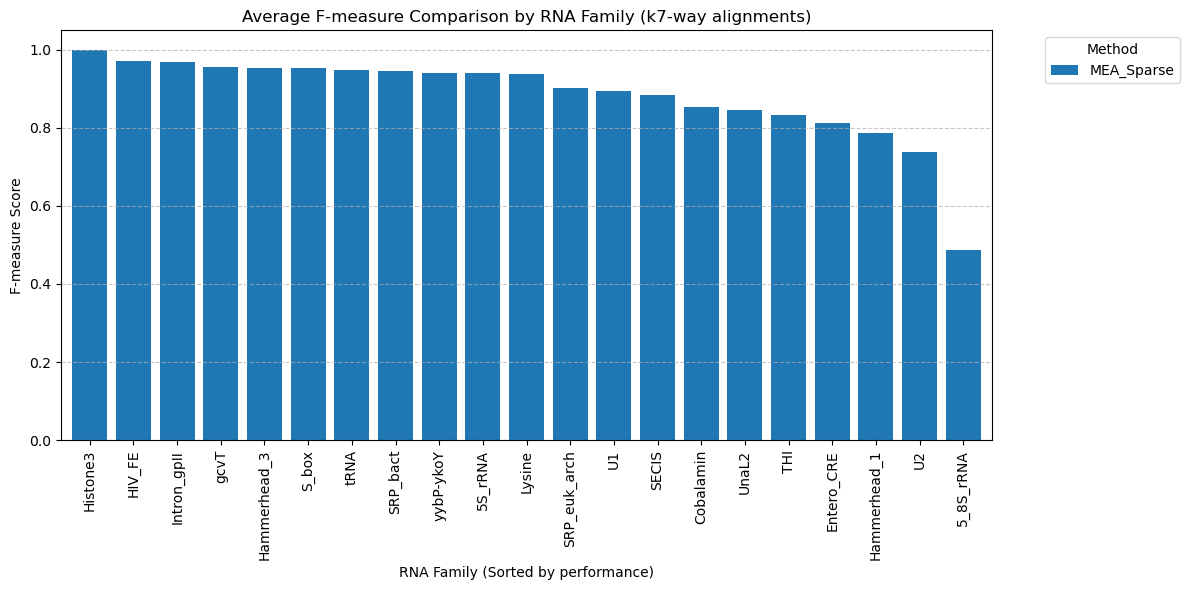

In [56]:
df_results = run_family_benchmark(benchmark_data, k_target='k7', alpha=8.5)
plot_benchmark_results(df_results, k_val='k7')

In [57]:
def run_comprehensive_benchmark(benchmark_data, k_target, alpha, l_factor=1.0, beta=0.6, num_samples=1000):
    """
    Runs a full benchmark including MEA Sparsified, Boltzmann Sampling, 
    Ensemble Diversity, and Local Entropy.
    """
    all_results = []
    
    if k_target not in benchmark_data:
        print(f"Error: {k_target} not found in benchmark data.")
        return None

    for family, alignments in benchmark_data[k_target].items():
        print(f"Processing family: {family}...")
        
        for i, alignment in enumerate(alignments):
            # 1. Reference Structure (RNAalifold)
            fc_ali = RNA.fold_compound(alignment)
            ref_ss, _ = fc_ali.mfe() 
            
            # 2. MEA Prediction Step
            # (Assuming get_mea_probabilities_with_mapping is defined)
            unp, pair = get_mea_probabilities_with_conservation_score(alignment, l_factor, alpha)
            
            start_time = time.time()
            res_mea_db = mea_structure_sparsified(unp, pair, m=3)
            exec_time = time.time() - start_time
            
            # 3. Standard Metrics (F-measure, Precision, etc.)
            metrics = benchmark_metrics(ref_ss, res_mea_db) 
            
            # 4. Boltzmann Sampling Step
            # Use the same probabilities but with the sampling beta
            samples = sample_structures_stable(unp, pair, beta, num_samples=num_samples, m=3)
            
            # 5. Advanced Metrics Calculation
            # Probability stats from samples
            prob_matrix, unp_probs_stats = get_probabilities_from_samples(samples)
            
            # Global metric: Diversity
            diversity = calculate_ensemble_diversity(samples)
            
            # Local metrics: Entropy and Reliability
            entropy_vector = calculate_local_measures(samples, prob_matrix, unp_probs_stats)
            avg_entropy = np.mean(entropy_vector)
            
            reliability_vector = get_mea_reliability(res_mea_db, prob_matrix, unp_probs_stats)
            avg_reliability = np.mean(reliability_vector)

            # 6. Consolidate Data
            res_entry = {
                "Family": family,
                "Instance": i,
                "Method": "MEA_Sparsified_Sampling",
                "Time": exec_time,
                "Ensemble_Diversity": diversity,
                "Mean_Local_Entropy": avg_entropy,
                "Mean_Reliability": avg_reliability,
                "k": k_target,
                **metrics # TP, FP, FN, Precision, Recall, F-measure
            }
            all_results.append(res_entry)
            
    return pd.DataFrame(all_results)

def plot_sampling_summary(df):
    plt.figure(figsize=(12, 6))
    # Comparison of Diversity vs Entropy per Family
    sns.scatterplot(data=df, x="Mean_Local_Entropy", y="Ensemble_Diversity", 
                    hue="Family", size="F-measure", sizes=(20, 200))
    plt.title("Structural Landscape Analysis: Entropy vs Diversity")
    plt.grid(True, alpha=0.3)
    plt.show()

Processing family: 5S_rRNA...


/var/folders/g3/5kdl364n7mv9ntsl8b3md3mr0000gn/T/ipykernel_39523/833422173.py:69: RuntimeWarning: divide by zero encountered in log2
  entropy[i] = -np.sum(probs * np.log2(probs))
/var/folders/g3/5kdl364n7mv9ntsl8b3md3mr0000gn/T/ipykernel_39523/833422173.py:69: RuntimeWarning: invalid value encountered in multiply
  entropy[i] = -np.sum(probs * np.log2(probs))


Processing family: Intron_gpII...
Processing family: U1...
Processing family: Hammerhead_1...
Processing family: SRP_bact...
Processing family: S_box...
Processing family: yybP-ykoY...
Processing family: gcvT...
Processing family: SECIS...
Processing family: 5_8S_rRNA...
Processing family: tRNA...
Processing family: Histone3...
Processing family: Entero_CRE...
Processing family: Hammerhead_3...
Processing family: U2...
Processing family: UnaL2...
Processing family: SRP_euk_arch...
Processing family: Cobalamin...
Processing family: Lysine...
Processing family: HIV_FE...
Processing family: THI...


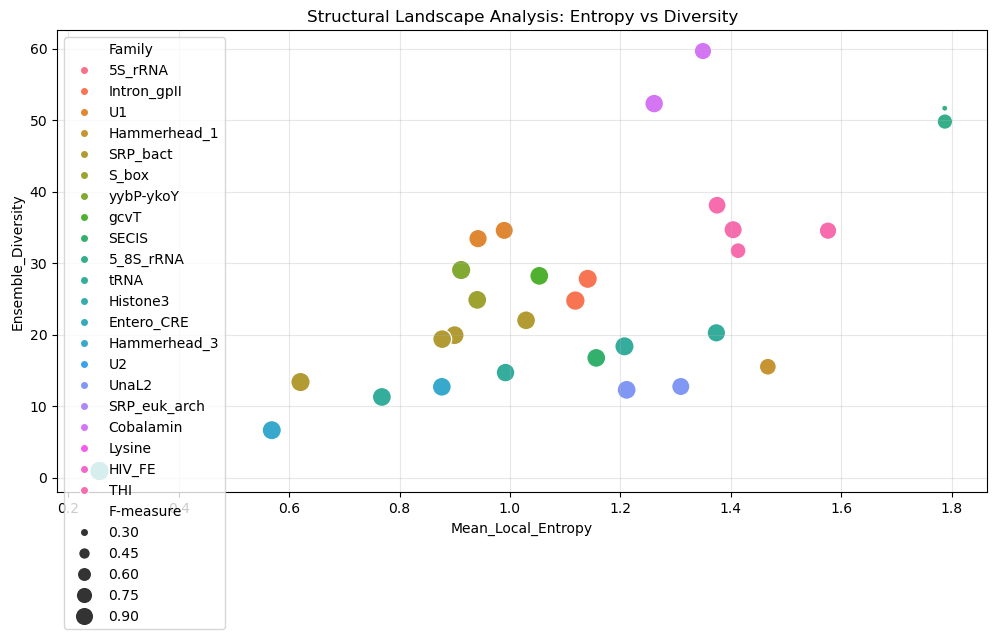

In [58]:
df_results = run_comprehensive_benchmark(benchmark_data, k_target='k7', alpha=8.5, l_factor=1.0, beta=0.2, num_samples=100)
plot_sampling_summary(df_results)

In [59]:
def plot_structural_analysis(sequence, entropy, reliability, family_name=""):
    """
    Plot thel local structural measures (entropy and reliability) along the sequence.
    """
    positions = np.arange(len(sequence))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Graphique de l'Entropie
    ax1.plot(positions, entropy, color='purple', lw=1.5, label='Entropy (Uncertainty)')
    ax1.fill_between(positions, entropy, color='purple', alpha=0.1)
    ax1.set_ylabel("Shannon Entropy (bits)")
    ax1.set_title(f"Local Structural analysis : {family_name}")
    ax1.grid(alpha=0.3)
    
    # Graphique de la Fiabilité
    ax2.bar(positions, reliability, color='teal', alpha=0.7, label='Reliability (Probability)')
    ax2.set_ylabel("Probability")
    ax2.set_xlabel("Nucleotide Position")
    ax2.set_ylim(0, 1.1)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

/var/folders/g3/5kdl364n7mv9ntsl8b3md3mr0000gn/T/ipykernel_39523/833422173.py:69: RuntimeWarning: divide by zero encountered in log2
  entropy[i] = -np.sum(probs * np.log2(probs))
/var/folders/g3/5kdl364n7mv9ntsl8b3md3mr0000gn/T/ipykernel_39523/833422173.py:69: RuntimeWarning: invalid value encountered in multiply
  entropy[i] = -np.sum(probs * np.log2(probs))


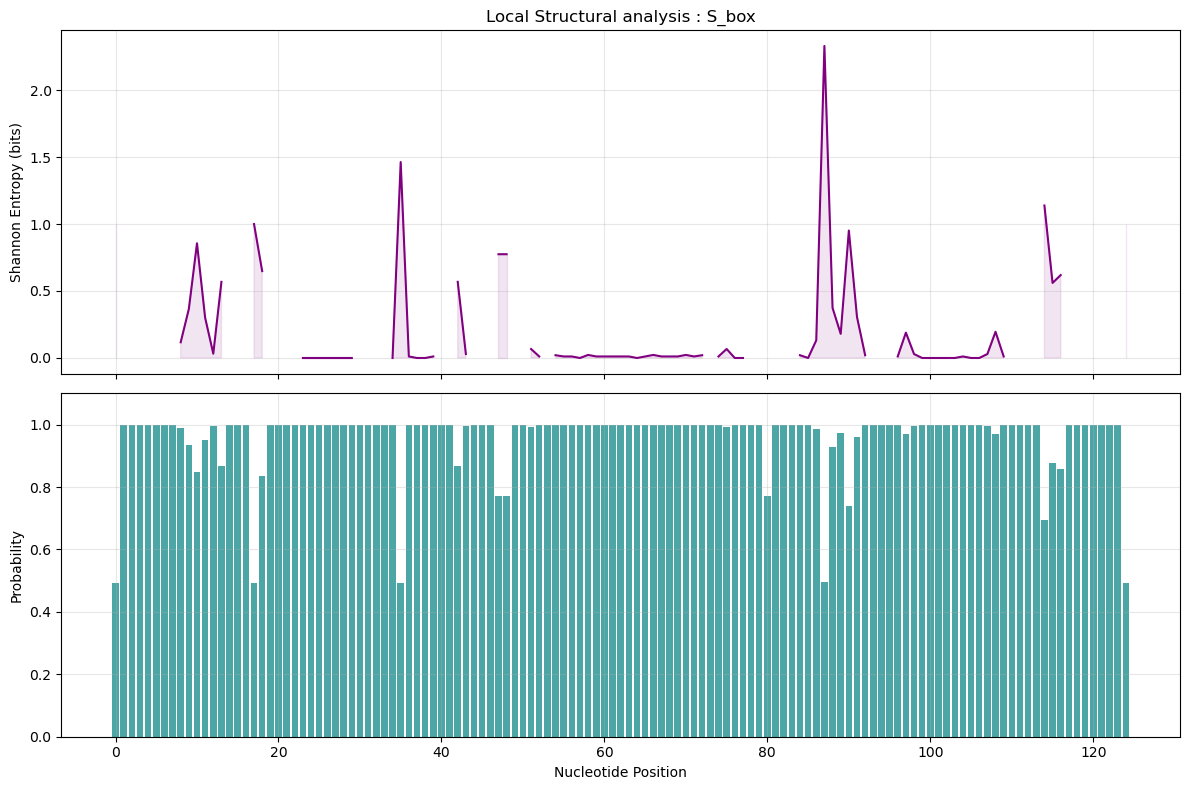

In [62]:
# --- Example for a certain family ---
family = 'S_box'
k_val = 'k7'


alignment_sequences = benchmark_data[k_val][family][0] 
unp_probs, pair_probs = get_mea_probabilities_with_conservation_score(
    alignment_sequences, l_factor=1.0, alpha=8.5
)

# Generate the Boltzmann ensemble
samples = sample_structures(unp_probs, pair_probs, beta=0.6, num_samples=1000)

# Calculate statistical probabilities and entropy from samples
prob_matrix, unp_stats = get_probabilities_from_samples(samples)
entropy = calculate_local_measures(samples, prob_matrix, unp_stats)


mea_result = mea_structure_sparsified(unp_probs, pair_probs, m=3)
reliability_mea = get_mea_reliability(mea_result, prob_matrix, unp_stats)

plot_structural_analysis(mea_result, entropy, reliability_mea, family)

### 4.2 Example with a RNAalifold strucutre + a different MEA structure + explication with boltzmann Sampling

### 4.2 Complexity analysis